In [1]:
'''
基于经典网络架构训练图像分类模型

1。数据预处理部分
2。网络模块设置
3。网络模型保存与测试
'''

'\n基于经典网络架构训练图像分类模型\n\n1。数据预处理部分\n2。网络模块设置\n3。网络模型保存与测试\n'

In [12]:
import os
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch
import torch.optim as optim
import torchvision
from torchvision import transforms, models, datasets
import imageio
import time
import warnings
warnings.filterwarnings("ignore")
import random
import sys
import copy
import json
from PIL import Image

data_dir = './flower_data/'
train_dir = data_dir +'/train'
valid_dir = data_dir + '/vaid'  #验证集


In [13]:
'''
1.1制作好数据源
 - data_transforms中指定了所有图像预处理操作
 - ImageFolder假设所有文件都按文件夹保存好，每个文件夹下面存储同一类别的图片，文件夹的名字就是分类的名字
'''
data_transforms = {
    'train': #训练集 - 数据增强 - 因为train数据集大小为6000左右，量不大，因此需要做数据增强去提升每一张图片的数据质量，以及增加不同角度的图片数据量
        transforms.Compose([
            transforms.Resize([96,96]), #将data中的图片数据大小统一:正方形
            #数据增强data augmentation：增加模型数据和多样性，随机旋转，-45到45度之间随机选,将同一张图片旋转，可以得到不同角度的图片，从而使数据量增加
            transforms.RandomRotation(45), #数据增强data augmentation
            #数据增强data augmentation：增加模型数据和多样性，从中心开始裁剪 -> 64 * 64是实际数据进行训练的输入大小
            transforms.CenterCrop(64), #图片裁剪大小，数据增强data augmentation
            transforms.RandomHorizontalFlip(p=0.5), #随机水平翻转， 选择一个概率
            transforms.RandomVerticalFlip(p=0.5), #随机垂直翻转， 选择一个概率
            #transforms.ColorJitter(brightness=0.2, contrast=0.1, saturation=0.1, hue=0.1),#亮度调整//一般不加
            #transforms.RandomGrayscale(p=0.025),#概率转换成灰度率，3通道就是R-G-B//一般不加
            transforms.ToTensor(),
            #标准化操作：通过 x-μ/σ，对RGB3个通道的值进行标准化 - μ[0.485(R), 0.456(G), 0.406(B)]，σ[0.229(R), 0.224(G),0.225](B)
            transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224,0.225]), #标准化操作
        ]),
    'valid':#验证集：不需要做数据增强， 只需要保持图片大小跟训练集一致 以及其它固定参数一致
        transforms.Compose([
            transforms.Resize([64,64]), ##验证数据的大小要跟训练数据一致，
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224,0.225]),
        ])
}

In [14]:
batch_size = 128
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'valid']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True) for x in ['train','valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train','valid']}
class_names = image_datasets['train'].classes #分类的名字，目录【1 - 101】

In [15]:
with open('category_number_to_name.json','r') as f:
    category_number_to_name = json.load(f)

In [16]:
#category_number_to_name

In [17]:
'''
加载和下载models中提供的模型，并且直接用训练的好权重当做初始化参数
 - 第一次执行需要下载，可能会比较慢，也可以下载下来直接导入
 - 现经典模型，好处1： 不用自己定义每一层的网络
              好处2： 不用验证自己定义每层网络的好坏
              好处3：经典模型的每层网络都是设计好，并且验证过的。

迁移学习（Transfer Learning)是一种机器学习方法，其核心思想是将一个领域（源域）学到的知识应用到另一个领域（目标任务域）的学习中去，
即使这两个领域的数据特征空间或分布存在

'''
model_name = 'resnet'  #特征提取器模型 - 可选选项：['resnet','alexnet','vgg','squeezenet','densenet','inception']
feature_extract = True #特征用模型自带的 feature extract from resnet

train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available')
else:
    print('CUDA is available!')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

CUDA is available!


In [18]:
# model_ft = models.resnet18()
# model_ft.parameters() #看看现成模型的网络结构 
# for name,param in model_ft.named_paramters():
#     print(name)
#     print(param)

In [19]:
'''
对于现成模型的参数要不要更新 param.requires_grad = True/False;
 - 可以选择不更新给定模型的weight
'''
from torch import nn
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False  ##反向传播的时候不传播梯度。

def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    model_ft = models.resnet18(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)
    num_features = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_features, 102) #输出类别总个数根据自己的任务来, 
    ##执行完上面新加层后，我们会发现，param.requires_grad又变成true了。

    input_size=64
    return model_ft, input_size

In [20]:
'''
设置哪些层需要训练
'''
model_ft,input_size = initialize_model(model_name, 102, feature_extract, use_pretrained=True)
model_ft = model_ft.to(device)

#保持模型到本地文件
filename = 'best_checkpoint.pt'
#是否训练所有层？
params_to_update = model_ft.parameters()
print("params to learn:")
if feature_extract:
    params_to_update = []
    for name, param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name, param in model_ft.named_paramters():
        if param.requires_grad:
            print("\t", name)

params to learn:
	 fc.weight
	 fc.bias


In [21]:
'''
优化器的设置
'''
optimizer_ft = optim.Adam(params_to_update, lr=1e-2)#要训练什么参数你来定，我们这个例子只更新FC全连接层
my_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)#学习率每7个epoch衰减成原来的1/10
loss_function = nn.CrossEntropyLoss() ##损失函数，交叉熵


In [22]:
'''
训练模块
'''
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25,filename='best.pt'):
    #咱们要算时间的
    since = time.time()
    #也要记录最好的那一次
    best_acc = 0
    #模型也得放到你的CPU或者GPU
    model.to(device)
    #训练过程中打印一堆损失和指标
    val_acc_history = []
    train_acc_history = []
    train_losses = []
    valid_losses = []
    #学习率
    LRs = [optimizer.param_groups[0]['lr']]
    #最好的那次模型，后续会变的，先初始化
    best_model_wts = copy.deepcopy(model.state_dict())
    #一个个epoch来遍历
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # 训练和验证
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # 训练
            else:
                model.eval()   # 验证

            running_loss = 0.0
            running_corrects = 0

            # 把数据都取个遍
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)#放到你的CPU或GPU
                labels = labels.to(device)

                # 清零
                optimizer.zero_grad()
                # 只有训练的时候计算和更新梯度
                outputs = model(inputs)
                loss = loss_function(outputs, labels)
                _, preds = torch.max(outputs, 1)
                # 训练阶段更新权重
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # 计算损失
                running_loss += loss.item() * inputs.size(0)#0表示batch那个维度
                running_corrects += torch.sum(preds == labels.data)#预测结果最大的和真实值是否一致
                
            
            
            epoch_loss = running_loss / len(dataloaders[phase].dataset)#算平均
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            time_elapsed = time.time() - since#一个epoch我浪费了多少时间
            print('Time elapsed {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            

            # 得到最好那次的模型
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                state = {
                  'state_dict': model.state_dict(),#字典里key就是各层的名字，值就是训练好的权重
                  'best_acc': best_acc,
                  'optimizer' : optimizer.state_dict(),
                }
                torch.save(state, filename)
            if phase == 'valid':
                val_acc_history.append(epoch_acc)
                valid_losses.append(epoch_loss)
                #my_lr_scheduler.step(epoch_loss)#学习率衰减
            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_losses.append(epoch_loss)
        
        print('Optimizer learning rate : {:.7f}'.format(optimizer.param_groups[0]['lr']))
        LRs.append(optimizer.param_groups[0]['lr'])
        print()
        my_lr_scheduler.step()#学习率衰减

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # 训练完后用最好的一次当做模型最终的结果,等着一会测试
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, train_acc_history, valid_losses, train_losses, LRs 
    

In [23]:
'''
开始正式调用上面的训练function
'''

model, val_acc_history, train_acc_history, valid_losses, train_losses, LRs = train_model(model_ft, dataloaders, loss_function, optimizer_ft)

Epoch 0/24
----------
Time elapsed 1m 38s
train Loss: 3.7087 Acc: 0.2877
Time elapsed 1m 50s
valid Loss: 3.8207 Acc: 0.2384
Optimizer learning rate : 0.0100000

Epoch 1/24
----------
Time elapsed 2m 25s
train Loss: 2.3957 Acc: 0.4750
Time elapsed 2m 29s
valid Loss: 3.7334 Acc: 0.3020
Optimizer learning rate : 0.0100000

Epoch 2/24
----------
Time elapsed 3m 3s
train Loss: 2.3338 Acc: 0.5026
Time elapsed 3m 7s
valid Loss: 3.7144 Acc: 0.3203
Optimizer learning rate : 0.0100000

Epoch 3/24
----------
Time elapsed 3m 42s
train Loss: 2.2476 Acc: 0.5134
Time elapsed 3m 46s
valid Loss: 3.8003 Acc: 0.3386
Optimizer learning rate : 0.0100000

Epoch 4/24
----------
Time elapsed 4m 20s
train Loss: 2.2252 Acc: 0.5299
Time elapsed 4m 24s
valid Loss: 3.9604 Acc: 0.3203
Optimizer learning rate : 0.0100000

Epoch 5/24
----------
Time elapsed 4m 59s
train Loss: 2.2134 Acc: 0.5337
Time elapsed 5m 3s
valid Loss: 4.1009 Acc: 0.3374
Optimizer learning rate : 0.0100000

Epoch 6/24
----------
Time elapsed 5m

In [24]:
'''
上面只是训练了最后一步的全连接层，接下来我们用上面训练出来的最好的结果，再进行训练（不再冻结之前的参数更新）
'''
filename ='best.pt'
for param in model_ft.parameters():
    param.requires_grad = True

# 再继续训练所有的参数，学习率调小一点
optimizer = optim.Adam(model_ft.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# 损失函数
criterion = nn.CrossEntropyLoss()

#加载上面训练好的最好一次的权重参数的文件
checkpoint = torch.load(filename)
best_acc = checkpoint['best_acc']
model_ft.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [25]:
'''
再一次开始正式调用上面的训练function
'''

model, val_acc_history, train_acc_history, valid_losses, train_losses, LRs = train_model(model_ft, dataloaders, loss_function, optimizer_ft,10)

Epoch 0/9
----------
Time elapsed 0m 35s
train Loss: 1.3408 Acc: 0.6674
Time elapsed 0m 39s
valid Loss: 3.3489 Acc: 0.3961
Optimizer learning rate : 0.0001000

Epoch 1/9
----------
Time elapsed 1m 13s
train Loss: 1.3080 Acc: 0.6758
Time elapsed 1m 17s
valid Loss: 3.3785 Acc: 0.3900
Optimizer learning rate : 0.0001000

Epoch 2/9
----------
Time elapsed 1m 52s
train Loss: 1.3089 Acc: 0.6748
Time elapsed 1m 56s
valid Loss: 3.3734 Acc: 0.3912
Optimizer learning rate : 0.0001000

Epoch 3/9
----------
Time elapsed 2m 30s
train Loss: 1.3092 Acc: 0.6645
Time elapsed 2m 34s
valid Loss: 3.3771 Acc: 0.3961
Optimizer learning rate : 0.0001000

Epoch 4/9
----------
Time elapsed 3m 8s
train Loss: 1.2955 Acc: 0.6697
Time elapsed 3m 12s
valid Loss: 3.3519 Acc: 0.3851
Optimizer learning rate : 0.0001000

Epoch 5/9
----------
Time elapsed 3m 47s
train Loss: 1.3079 Acc: 0.6703
Time elapsed 3m 51s
valid Loss: 3.3215 Acc: 0.3973
Optimizer learning rate : 0.0000100

Epoch 6/9
----------
Time elapsed 4m 26s


In [26]:
'''加载训练好的模型'''
model_ft, input_size = initialize_model(model_name, 102, feature_extract, use_pretrained=True)

# GPU模式
model_ft = model_ft.to(device)

# 保存文件的名字
filename='best.pt'

# 加载模型
checkpoint = torch.load(filename)
best_acc = checkpoint['best_acc']
model_ft.load_state_dict(checkpoint['state_dict'])


<All keys matched successfully>

In [27]:
'''
最后：测试数据预处理
测试数据处理方法需要跟训练时一直才可以
crop操作的目的是保证输入的大小是一致的
标准化操作也是必须的，用跟训练数据相同的mean和std,但是需要注意一点训练数据是在0-1上进行标准化，所以测试数据也需要先归一化
最后一点，PyTorch中颜色通道是第一个维度，跟很多工具包都不一样，需要转换
'''
# 得到一个batch的测试数据
dataiter = iter(dataloaders['valid'])
images, labels = next(dataiter)

model_ft.eval()

if train_on_gpu:
    output = model_ft(images.cuda())
else:
    output = model_ft(images) #output表示对一个batch中每一个数据得到其属于各个类别的可能性


In [28]:
'''得到概率最大的那个'''
_, preds_tensor = torch.max(output, 1)

#GPU data to CPU data
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())



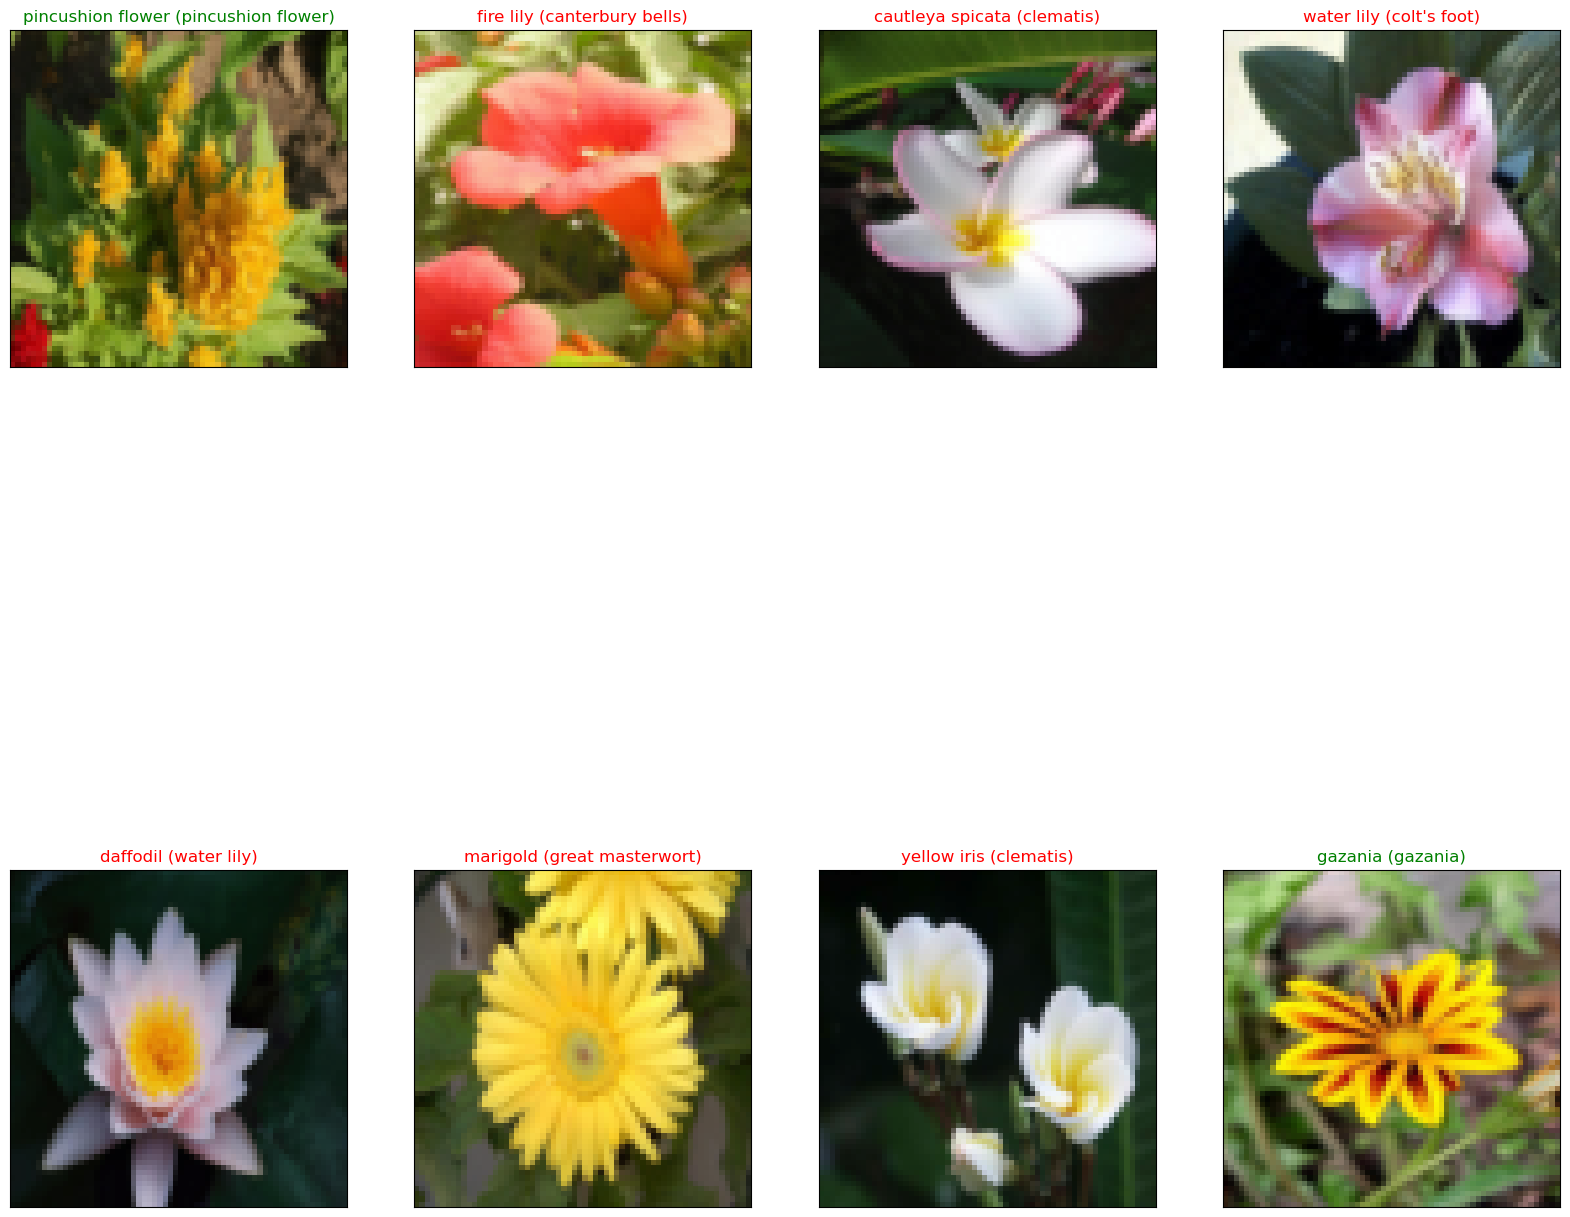

In [29]:
'''展示预测结果'''
def im_convert(tensor):
    """ 展示数据"""
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)  ###转换维度(3*64*64) -> (64, 64, 3)正常图片的维度
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406)) #还原真实的图片
    image = image.clip(0, 1)

    return image

fig=plt.figure(figsize=(20, 20))
columns =4
rows = 2

for idx in range (columns*rows):
    ax = fig.add_subplot(rows, columns, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title("{} ({})".format(category_number_to_name[str(preds[idx])], category_number_to_name[str(labels[idx].item())]),
                 color=("green" if category_number_to_name[str(preds[idx])]==category_number_to_name[str(labels[idx].item())] else "red"))
plt.show()